In [32]:
from model import trainfunc
import numpy as np
import torch
import torch.utils
import h5py
import matplotlib.pyplot as plt
import cv2, copy

In [15]:
device = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')

In [16]:
f = h5py.File('./data/sample_A_20160501.hdf', 'r')

train_x = torch.zeros((f['/volumes/raw'].shape[0],512,512))
for i in range(train_x.shape[0]):
    train_x[i] = torch.from_numpy(cv2.resize(f['/volumes/raw'][i],(512, 512)))
dummy_y = torch.zeros(train_x.shape[0])

# N, C, D, W, H
x_sequences = torch.zeros((f['/volumes/raw'].shape[0] - 3,1,3,1024,1024))
y_label = torch.zeros((f['/volumes/raw'].shape[0] - 3,1,1,1024,1024))

for i in range(f['/volumes/raw'].shape[0] - 3):
    x_sequences[i, 0, 0,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i],(1024, 1024)))
    x_sequences[i, 0, 1,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 1],(1024, 1024)))
    x_sequences[i, 0, 2,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 2],(1024, 1024)))
    
    y_label[i, 0, 0,:,:] = torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 3],(1024, 1024)))
    

# 10 random patches, 4 ori, 3 flip, 2 rotated, 1 noise
def augment(x, y, aug = True):
    new_x = torch.zeros(x.shape[0] * 10, *x.shape[1:3], 512, 512)
    new_y = torch.zeros(y.shape[0] * 10, *y.shape[1:3], 512, 512)
    
    for i in range(x.shape[0]):
        new_anchors = np.random.randint(0, 511, (10, 2))
        for j, anchor in enumerate(new_anchors):
            new_x[i * 10 + j, :, :, :, :] = x[i, :, :, 
                                              anchor[0]:anchor[0] + 512, 
                                              anchor[1]:anchor[1] + 512]
            new_y[i * 10 + j, :, :, :, :] = y[i, :, :, 
                                              anchor[0]:anchor[0] + 512, 
                                              anchor[1]:anchor[1] + 512]
        if aug:
            new_x[i * 10 + 4, :, :, :, :] = torch.flip(new_x[i * 10 + 4, :, :, :, :], [2])
            new_x[i * 10 + 5, :, :, :, :] = torch.flip(new_x[i * 10 + 5, :, :, :, :], [3])
            new_x[i * 10 + 6, :, :, :, :] = torch.flip(new_x[i * 10 + 6, :, :, :, :], [2, 3])
            new_y[i * 10 + 4, :, :, :, :] = torch.flip(new_y[i * 10 + 4, :, :, :, :], [2])
            new_y[i * 10 + 5, :, :, :, :] = torch.flip(new_y[i * 10 + 5, :, :, :, :], [3])
            new_y[i * 10 + 6, :, :, :, :] = torch.flip(new_y[i * 10 + 6, :, :, :, :], [2, 3])
            
            new_x[i * 10 + 7, :, :, :, :] = torch.rot90(new_x[i * 10 + 7, :, :, :, :],1, [2, 3])
            new_x[i * 10 + 8, :, :, :, :] = torch.rot90(new_x[i * 10 + 8, :, :, :, :],-1, [2, 3])
            new_y[i * 10 + 7, :, :, :, :] = torch.rot90(new_y[i * 10 + 7, :, :, :, :],1, [2, 3])
            new_y[i * 10 + 8, :, :, :, :] = torch.rot90(new_y[i * 10 + 8, :, :, :, :],-1, [2, 3])
            
            new_x[i * 10 + 9, :, :, :, :] = new_x[i * 10 + 9, :, :, :, :] + torch.randn((1,1,512,512))
    return new_x, new_y

In [17]:
aug_x, aug_y = augment(x_sequences, y_label)

dataset = torch.utils.data.TensorDataset(aug_x, aug_y)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = True)

*torch.nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')*

In [18]:
class toynet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.1, inplace = True)
        self.down1 = torch.nn.Conv3d(1, 32, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3， 512， 512
        self.down2 = torch.nn.Conv3d(32, 64, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3， 256, 256
        self.down3 = torch.nn.Conv3d(64, 128, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3， 128, 128
        self.down4 = torch.nn.Conv3d(128, 256, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3， 64, 64
        self.down5 = torch.nn.Conv3d(256, 256, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3， 32, 32
        
        self.down6 = torch.nn.Conv3d(256, 512, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 16, 16
        
        self.up5 = torch.nn.ConvTranspose3d(512, 256, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 32, 32
        self.up4 = torch.nn.ConvTranspose3d(256+256, 128, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 64, 64
        self.up3 = torch.nn.ConvTranspose3d(128+256, 64, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 128, 128
        self.up2 = torch.nn.ConvTranspose3d(64+128, 32, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 256, 256
        self.up1 = torch.nn.ConvTranspose3d(32+64, 16, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 512, 512
        self.up0 = torch.nn.ConvTranspose3d(16+32, 8, kernel_size = (3,2,2), padding = (1,0,0), stride=(1,2,2)) # 3, 1024, 1024
        
        self.final = torch.nn.Conv3d(8+1, 1, kernel_size = 3, padding = (1, 1, 1)) # 1, 1024, 1024
    def forward(self, x):
#         assert(x.shape[-2:]==(1024,1024))
        x0 = x.detach().clone() # 1, 3, 1024, 1024
        
        xdown1 = self.down1(x0) # 32, 3, 512, 512
        xdown1 = self.act(xdown1)
        
        xdown2 = self.down2(xdown1) # 64, 3, 256, 256
        xdown2 = self.act(xdown2)
        
        xdown3 = self.down3(xdown2) # 128, 3, 128, 128
        xdown3 = self.act(xdown3)
        
        xdown4 = self.down4(xdown3) # 256, 3, 64, 64
        xdown4 = self.act(xdown4)
        
        xdown5 = self.down5(xdown4) # 256, 3, 32, 32
        xdown5 = self.act(xdown5)
        
        xdown6 = self.down6(xdown5) # 512, 3, 16, 16
        xdown6 = self.act(xdown6)
        
        xup5 = self.up5(xdown6)
        xup5 = self.act(xup5)
        xup5 = torch.cat((xup5,xdown5),1) # pos 1 is channel
        
        
        xup4 = self.up4(xup5)
        xup4 = self.act(xup4)
        xup4 = torch.cat((xup4,xdown4),1)
        
        
        xup3 = self.up3(xup4)
        xup3 = self.act(xup3)
        xup3 = torch.cat((xup3,xdown3),1)
        
        
        xup2 = self.up2(xup3)
        xup2 = self.act(xup2)
        xup2 = torch.cat((xup2,xdown2),1)
        
        xup1 = self.up1(xup2)
        xup1 = self.act(xup1)
        xup1 = torch.cat((xup1,xdown1),1)
        
        xup0 = self.up0(xup1)
        xup0 = self.act(xup0)
        xup0 = torch.cat((xup0,x0),1)
        
        x = self.final(xup0)
#         del x0,xdown1,xdown2,xdown3,xdown5,xdown6
#         del xup0,xup1,xup2,xup3,xup4,xup5
#         print(torch.cuda.memory_allocated()//(1024 * 1024))
        return x

In [36]:
model = toynet().to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             weight_decay=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
def custom_mse(x, y):
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    return torch.mean(torch.pow((x - y),2).float().flatten())

criterion = custom_mse

In [37]:
import torchsummary
torchsummary.summary(model,(1,3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 3, 128, 128]             416
         LeakyReLU-2      [-1, 32, 3, 128, 128]               0
            Conv3d-3        [-1, 64, 3, 64, 64]          24,640
         LeakyReLU-4        [-1, 64, 3, 64, 64]               0
            Conv3d-5       [-1, 128, 3, 32, 32]          98,432
         LeakyReLU-6       [-1, 128, 3, 32, 32]               0
            Conv3d-7       [-1, 256, 3, 16, 16]         393,472
         LeakyReLU-8       [-1, 256, 3, 16, 16]               0
            Conv3d-9         [-1, 256, 3, 8, 8]         786,688
        LeakyReLU-10         [-1, 256, 3, 8, 8]               0
           Conv3d-11         [-1, 512, 3, 4, 4]       1,573,376
        LeakyReLU-12         [-1, 512, 3, 4, 4]               0
  ConvTranspose3d-13         [-1, 256, 3, 8, 8]       1,573,120
        LeakyReLU-14         [-1, 256, 

In [38]:
num_epochs = 100
best_loss=1e10
best_model_wts = copy.deepcopy(model.state_dict())
model.train()
for epoch in range(num_epochs):
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    exp_lr_scheduler.step()
    print('epoch [{}/{}], loss:{:.4f}'
      .format(epoch+1, num_epochs, loss.item()))
    if loss < best_loss:
        print("saving best model")
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
#     if epoch % 2 == 0:
#         pic = to_img(output.cpu().data)
#         torchvison.save_image(pic, './ae_dst/image_{}.png'.format(epoch))
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), './EMnet.pth')

epoch [1/100], loss:654.7502
saving best model
epoch [2/100], loss:551.6954
saving best model
epoch [3/100], loss:466.6677
saving best model
epoch [4/100], loss:379.3068
saving best model
epoch [5/100], loss:388.2243
epoch [6/100], loss:584.2893
epoch [7/100], loss:567.6817
epoch [8/100], loss:526.6000
epoch [9/100], loss:460.8720
epoch [10/100], loss:508.0523
epoch [11/100], loss:398.4583
epoch [12/100], loss:619.7751
epoch [13/100], loss:648.3041
epoch [14/100], loss:547.1718
epoch [15/100], loss:465.1488
epoch [16/100], loss:435.9567
epoch [17/100], loss:368.9211
saving best model
epoch [18/100], loss:433.1389
epoch [19/100], loss:473.5295
epoch [20/100], loss:452.0676
epoch [21/100], loss:616.2120
epoch [22/100], loss:466.5450
epoch [23/100], loss:430.3569
epoch [24/100], loss:361.7742
saving best model
epoch [25/100], loss:455.9668
epoch [26/100], loss:370.7315
epoch [27/100], loss:461.6118
epoch [28/100], loss:412.0559
epoch [29/100], loss:449.9048
epoch [30/100], loss:296.1632
s

In [ ]:
model.train()
for epoch in range(num_epochs):
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    exp_lr_scheduler.step()
    print('epoch [{}/{}], loss:{:.4f}'
      .format(epoch+1, num_epochs, loss.item()))
    if loss < best_loss:
        print("saving best model")
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
#     if epoch % 2 == 0:
#         pic = to_img(output.cpu().data)
#         torchvison.save_image(pic, './ae_dst/image_{}.png'.format(epoch))
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), './EMnet2.pth')

torch.Size([16, 1, 3, 512, 512])


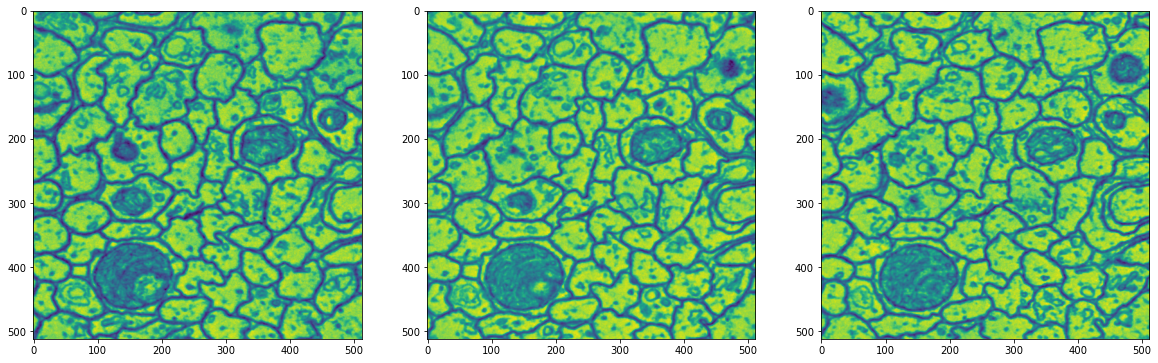

dst torch.Size([16, 1, 3, 512, 512])


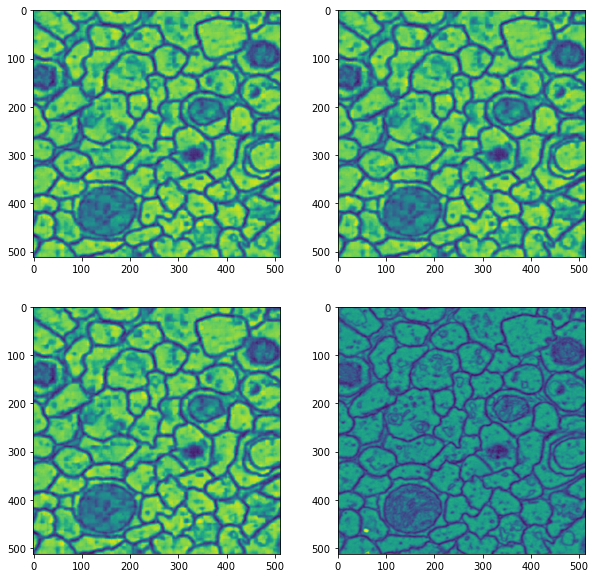

tensor(213.4115)
torch.Size([16, 1, 3, 512, 512]) torch.Size([16, 1, 1, 512, 512])


In [48]:
for i,j in dataloader:
    print(i.shape)
    plt.figure(figsize=(20,10))
    plt.subplot(131),plt.imshow(i[0,0,0,:,:])
    plt.subplot(132),plt.imshow(i[0,0,1,:,:])
    plt.subplot(133),plt.imshow(i[0,0,2,:,:])
    plt.show()
    dst = model(i.to(device)).detach().cpu()
    print("dst", dst.shape)
    plt.figure(figsize=(10,10))
    plt.subplot(221),plt.imshow(dst[0,0,0,:,:])
    plt.subplot(222),plt.imshow(dst[0,0,1,:,:])
    plt.subplot(223),plt.imshow(dst[0,0,2,:,:])
    plt.subplot(224),plt.imshow(j[0,0,0,:,:])
    plt.show()
    print(criterion(dst[0,0,0,:,:], j[0,0,0,:,:]))
    print(dst.shape, j.shape)
    break

torch.Size([1, 1, 3, 512, 512])


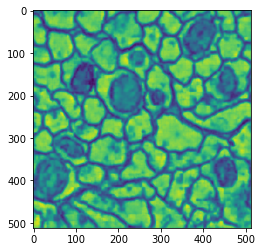

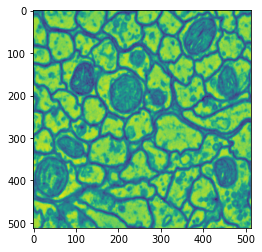

tensor(241.6591)
torch.Size([1, 1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512])


In [44]:
test_x = torch.zeros((f['/volumes/raw'].shape[0],512,512))
for i in range(test_x.shape[0]):
    test_x[i] = torch.from_numpy(cv2.resize(f['/volumes/raw'][i],(512, 512)))
test_input = torch.zeros((f['/volumes/raw'].shape[0] - 3, 1, 3, 512, 512))
test_label = torch.zeros((f['/volumes/raw'].shape[0] - 3, 1, 1, 512, 512))
for i in range(test_x.shape[0] - 3):
    test_input[i, 0, 0, :, :] = test_x[i]
    test_input[i, 0, 1, :, :] = test_x[i + 1]
    test_input[i, 0, 2, :, :] = test_x[i + 2]
    
    test_label[i, 0, 0, :, :] = test_x[i + 3]
    
testset = torch.utils.data.TensorDataset(test_input, test_label)
testloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = True)

for i,j in testloader:
    print(i.shape)
    dst = model(i.to(device)).detach().cpu()
    plt.imshow(dst[0,0,0,:,:])
    plt.show()
    plt.imshow(j[0,0,0,:,:])
    plt.show()
    print(criterion(dst[0,0,0,:,:], j[0,0,0,:,:]))
    print(dst.shape, j.shape)
    break

In [27]:
a = torch.tensor([[[3,3],[2,2],[1,1]],[[3,3],[2,2],[1,1]]])
b = torch.tensor([[[1,1]]])

In [29]:
a - b

tensor([[[2, 2],
         [1, 1],
         [0, 0]],

        [[2, 2],
         [1, 1],
         [0, 0]]])

In [104]:
f = h5py.File('./data/sample_A_20160501.hdf', 'r')

train_x = torch.zeros((f['/volumes/raw'].shape[0],512,512))
for i in range(train_x.shape[0]):
    train_x[i] = torch.from_numpy(cv2.resize(f['/volumes/raw'][i],(512, 512)))
dummy_y = torch.zeros(train_x.shape[0])

# N, C, D, W, H
x_sequences = torch.zeros((f['/volumes/raw'].shape[0] - 3,1,3,1024,1024))
y_label = torch.zeros((f['/volumes/raw'].shape[0] - 3,1,1,1024,1024))

for i in range(f['/volumes/raw'].shape[0] - 3):
    x_sequences[i, 0, 0,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i],(1024, 1024)))
    x_sequences[i, 0, 1,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 1],(1024, 1024)))
    x_sequences[i, 0, 2,:,:] =  torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 2],(1024, 1024)))
    
    y_label[i, 0, 0,:,:] = torch.from_numpy(cv2.resize(f['/volumes/raw'][i + 3],(1024, 1024)))
    

# 10 random patches, 4 ori, 3 flip, 2 rotated, 1 noise
def augment(x, y, aug = True):
    new_x = torch.zeros(x.shape[0] * 10, *x.shape[1:3], 512, 512)
    new_y = torch.zeros(y.shape[0] * 10, *y.shape[1:3], 512, 512)
    
    for i in range(x.shape[0]):
        new_anchors = np.random.randint(0, 511, (10, 2))
        for j, anchor in enumerate(new_anchors):
            new_x[i * 10 + j, :, :, :, :] = x[i, :, :, 
                                              anchor[0]:anchor[0] + 512, 
                                              anchor[1]:anchor[1] + 512]
            new_y[i * 10 + j, :, :, :, :] = y[i, :, :, 
                                              anchor[0]:anchor[0] + 512, 
                                              anchor[1]:anchor[1] + 512]
        if aug:
            new_x[i * 10 + 4, :, :, :, :] = torch.flip(new_x[i * 10 + 4, :, :, :, :], [2])
            new_x[i * 10 + 5, :, :, :, :] = torch.flip(new_x[i * 10 + 5, :, :, :, :], [3])
            new_x[i * 10 + 6, :, :, :, :] = torch.flip(new_x[i * 10 + 6, :, :, :, :], [2, 3])
            new_y[i * 10 + 4, :, :, :, :] = torch.flip(new_y[i * 10 + 4, :, :, :, :], [2])
            new_y[i * 10 + 5, :, :, :, :] = torch.flip(new_y[i * 10 + 5, :, :, :, :], [3])
            new_y[i * 10 + 6, :, :, :, :] = torch.flip(new_y[i * 10 + 6, :, :, :, :], [2, 3])
            
            new_x[i * 10 + 7, :, :, :, :] = torch.rot90(new_x[i * 10 + 7, :, :, :, :],1, [2, 3])
            new_x[i * 10 + 8, :, :, :, :] = torch.rot90(new_x[i * 10 + 8, :, :, :, :],-1, [2, 3])
            new_y[i * 10 + 7, :, :, :, :] = torch.rot90(new_y[i * 10 + 7, :, :, :, :],1, [2, 3])
            new_y[i * 10 + 8, :, :, :, :] = torch.rot90(new_y[i * 10 + 8, :, :, :, :],-1, [2, 3])
            
            new_x[i * 10 + 9, :, :, :, :] = new_x[i * 10 + 9, :, :, :, :] + torch.randn((1,1,512,512))
    return new_x, new_y

In [109]:
aug_x, aug_y = augment(x_sequences, y_label)

dataset = torch.utils.data.TensorDataset(aug_x, aug_y)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = True)